In [114]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Create a heatmap
import seaborn as sns
import matplotlib
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import networkx as nx
# matplotlib.use('TkAgg')

In [128]:

# data_folder = '/home/jaume/Desktop/Data/New_ACDC/MIDS/mixed/derivatives/'
derivatives_path = "/media/jaume/DATA/Data/Urblauna_SFTP/UKB_Cardiac_BIDS/derivatives"
experiment_name = 'GraphClassification'

# Get the list of subjects
biomarkers_filename = os.path.join(derivatives_path, 'biomarkers.csv')
df_biomarkers = pd.read_csv(biomarkers_filename, index_col=0)

metadata_filename = os.path.join(derivatives_path, 'metadata_participants_numeric.csv')
df_numeric_metadata = pd.read_csv(metadata_filename, index_col=0)

merged_filename = os.path.join(derivatives_path, 'metadata_participants_biomarkers.csv')
df_merged = pd.read_csv(merged_filename, index_col=0)

In [129]:
# df_biomarkers

In [130]:
# ==== UKB
derivatives_folder = "/media/jaume/DATA/Data/Urblauna_SFTP/UKB_Cardiac_BIDS/derivatives"
data_path = os.path.join(derivatives_folder, 'GraphClassification')
all_edges = 'Edges-True_Norm-ZNorm_Global-True_All-True_Sim-False_BP-False'
aha_edges = 'Edges-True_Norm-ZNorm_Global-True_All-False_Sim-False_BP-False'
# study_name = 'Multiplex_HPT_ACDC_ADAM_FINAL_MAE'

# =========================== ALL ===========================
study_name = 'Multiplex_HPT_UKB_DIMENSIONS_NEW_LOSS_ALL'
all_data_folder = os.path.join(data_path, all_edges, study_name)  # save_folder

# =========================== AHA ===========================
study_name = 'Multiplex_HPT_UKB_DIMENSIONS_NEW_LOSS'
aha_data_folder = os.path.join(data_path, aha_edges, study_name)  # save_folder

save_folder = os.path.join(all_data_folder, 'latent_analysis') 
latent_filename = os.path.join(all_data_folder, 'latent_data.csv')
save_folder = os.path.join(aha_data_folder, 'latent_analysis') 
latent_filename = os.path.join(aha_data_folder, 'latent_data.csv')
reprocess_datasets = True
os.makedirs(save_folder, exist_ok=True)

df_latent = pd.read_csv(latent_filename) # -- Need to identify the subjects!

In [131]:
df_latent['Subject'] = df_biomarkers['Subject'].copy()
# df_latent
drop_columns=['Region', 'Cycle', 'dt', 'ed_cycle_time', 'es_cycle_time', 'ed_frame_idx', 'es_frame_idx', 'Height']

In [132]:
print(list(df_merged.columns))
# df_merged['Group']
df_merged.drop(columns=['Group'], inplace=True)
drop_columns_biomarkers = ['LV_SV', 'LV_Myo_EF', 'LV_Myo_SV', 'RV_SV', 'RV_Myo_SV', 'RV_Myo_EF', 'RV_Myo_SVI', 'LV_Myo_SVI']
df_merged[['RVMI']] = df_merged[['RV_Myo_SVI']] * 1.05
df_merged[['LVMI']] = df_merged[['LV_Myo_SVI']] * 1.05

['Subject', 'LV_Myo_Strain_Radial_Contraction', 'LV_Myo_Strain_Circum_Contraction', 'LV_Myo_Strain_Radial_Relaxation', 'LV_Myo_Strain_Circum_Relaxation', 'LV_Myo_Strain_Radial_Early_Relaxation', 'LV_Myo_Strain_Circum_Early_Relaxation', 'LV_Myo_Strain_Radial_Ratio', 'LV_Myo_Strain_Circum_Ratio', 'LV_Myo_Strain_Radial_Ratio_Early', 'LV_Myo_Strain_Circum_Ratio_Early', 'RV_Myo_Strain_Radial_Contraction', 'RV_Myo_Strain_Circum_Contraction', 'RV_Myo_Strain_Radial_Relaxation', 'RV_Myo_Strain_Circum_Relaxation', 'RV_Myo_Strain_Radial_Early_Relaxation', 'RV_Myo_Strain_Circum_Early_Relaxation', 'RV_Myo_Strain_Radial_Ratio', 'RV_Myo_Strain_Circum_Ratio', 'RV_Myo_Strain_Radial_Ratio_Early', 'RV_Myo_Strain_Circum_Ratio_Early', 'LV_Myo_Max Thickness', 'LV_Myo_Min Thickness', 'LV_Myo_Std Thickness', 'LV_Myo_Mean Thickness', 'LV_Myo_Max Radial Strain', 'LV_Myo_Max Circum Strain', 'RV_Myo_Max Thickness', 'RV_Myo_Min Thickness', 'RV_Myo_Std Thickness', 'RV_Myo_Mean Thickness', 'RV_Myo_Max Radial Strain'

In [134]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Prepare data for the regression analysis
y_df = df_merged.copy()
y_df.drop(columns=drop_columns, inplace=True)  # Remove non-feature columns
y_df.drop(columns=drop_columns_biomarkers, inplace=True)
y_df.set_index('Subject', inplace=True)

y_df = y_df.loc[:, y_df.isnull().mean() < 0.3]
# imputer = KNNImputer(n_neighbors=5)
# y_df_imputed = pd.DataFrame(imputer.fit_transform(y_df), columns=y_df.columns, index=y_df.index)
imputer = IterativeImputer(random_state=42)
y_df_imputed = pd.DataFrame(imputer.fit_transform(y_df), columns=y_df.columns, index=y_df.index)

/home/jaume/miniconda3/envs/pyMultiplex/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [135]:

missing_counts = y_df.isna().sum()
print(list(missing_counts[missing_counts > 0].sort_values().index))

['left_hand_grip_strength_2.0', 'right_hand_grip_strength_2.0', 'whistling_chest_last_year_2.0', 'shortness_breath_walking_2.0', 'Chest_pain_2.0', 'us_mean_imt_150_2.0', 'us_max_imt_150_2.0', 'us_min_imt_150_2.0', 'us_mean_imt_210_2.0', 'us_max_imt_210_2.0', 'urine_creatinine_0.0', 'us_min_imt_210_2.0', 'urine_sodium_0.0', 'us_min_imt_120_2.0', 'us_mean_imt_120_2.0', 'us_max_imt_120_2.0', 'urine_potassium_0.0', 'haemoglobin_concentration_0.0', 'haematocrit_percentage_0.0', 'us_min_imt_240_2.0', 'pwa_brachial_dbp_2.0', 'pwa_central_pulse_pressure_2.0', 'pwa_heart_rate_2.0', 'pwa_brachial_sbp_2.0', 'pwa_end_sp_2.0', 'pwa_total_peripheral_resistance_2.0', 'pwa_central_augmentation_pressure_2.0', 'pwa_peripheral_pulse_pressure_2.0', 'pwa_central_sbp_2.0', 'pwa_mean_arterial_pressure_2.0', 'us_mean_imt_240_2.0', 'us_max_imt_240_2.0', 'prot_creatinine_0.0', 'prot_tryglycerides_0.0', 'prot_cholesterol_0.0', 'prot_c_reactive_0.0', 'prot_ldl_0.0', 'prot_HbA1c_0.0', 'pwa_end_sp_index_2.0', 'pwa_

In [137]:
# Prepare data for the regression analysis
y_df = y_df_imputed.copy()
# y_df = df_merged.copy()
# y_df.dropna(axis=1, inplace=True)
X = y_df.values

X_df = df_latent.copy()
X_df.drop(columns=['Sample', 'labels'], inplace=True)  # Remove non-feature columns
X_df.set_index('Subject', inplace=True)
# X = X_df.values
# l2_distance = ((X_df - X_df.mean(axis=0))**2).sum(axis=1)**0.5
# y = l2_distance.values
# y = X_df

feature_names = y_df.columns.tolist()
# y

In [138]:
print(X_df.columns)
print(y_df.columns)

Index(['Node_0_Control_0', 'Node_1_Control_0', 'Node_2_Control_0',
       'Node_3_Control_0', 'Node_4_Control_0', 'Node_5_Control_0',
       'Node_6_Control_0', 'Node_7_Control_0', 'Node_8_Control_0',
       'Node_9_Control_0',
       ...
       'Node_15_Init_6', 'Node_16_Init_6', 'Node_17_Init_6', 'Node_18_Init_6',
       'Node_19_Init_6', 'Node_20_Init_6', 'Node_21_Init_6', 'Node_22_Init_6',
       'Node_23_Init_6', 'Node_24_Init_6'],
      dtype='object', length=450)
Index(['LV_Myo_Strain_Radial_Contraction', 'LV_Myo_Strain_Circum_Contraction',
       'LV_Myo_Strain_Radial_Relaxation', 'LV_Myo_Strain_Circum_Relaxation',
       'LV_Myo_Strain_Radial_Early_Relaxation',
       'LV_Myo_Strain_Circum_Early_Relaxation', 'LV_Myo_Strain_Radial_Ratio',
       'LV_Myo_Strain_Circum_Ratio', 'LV_Myo_Strain_Radial_Ratio_Early',
       'LV_Myo_Strain_Circum_Ratio_Early',
       ...
       'us_min_imt_210_2.0', 'us_mean_imt_210_2.0', 'us_max_imt_210_2.0',
       'us_min_imt_240_2.0', 'us_mean_imt_

In [139]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score
# from tqdm import tqdm

# # Assumes X_df and y_df are defined and aligned (same index)

# rf_params = {
#     'n_estimators': 501,
#     'random_state': 42,
#     'max_depth': 20,
#     'max_samples': 0.8,
#     'criterion': 'absolute_error'
# }

# r2_scores = {}
# importances_dict = {}

# for target in tqdm(y_df.columns, desc="Fitting models"):
#     y = y_df[target]
#     model = RandomForestRegressor(**rf_params)
#     model.fit(X_df, y)

#     y_pred = model.predict(X_df)
#     r2_scores[target] = r2_score(y, y_pred)
#     importances_dict[target] = model.feature_importances_

# # Create output DataFrames
# r2_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R2'])
# importances_df = pd.DataFrame(importances_dict, index=X_df.columns).T

In [140]:
# # Save R² scores
# r2_df.to_csv(os.path.join(save_folder, "rf_r2_scores.csv"))

# # Save feature importances
# importances_df.to_csv(os.path.join(save_folder, "rf_feature_importances.csv"))


In [141]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


param_grid = {
    'max_depth': [6, 10],
    'max_samples': [0.7, 0.9],
    'n_estimators': [51, 101],
    'max_features': ['sqrt', 0.3, 0.7],
    'min_samples_leaf': [1, 3, 5],
}

param_grid_xgb = {
    'max_depth': [3, 6],
    'n_estimators': [51, 101],
    # 'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.9],
    # 'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10]
}

# Params
n_jobs = 3
n_permutations = 100

rf_params = {
    'n_estimators': 101,
    'random_state': 42,
    'max_depth': 10,
    'max_samples': 0.7,
    # 'min_samples_split': 2,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'criterion': 'squared_error',
    'n_jobs': 3
}

xgb_params = {
    'n_estimators': 51,
    'max_depth': 5, 
    'subsample': 0.7,
    'learning_rate': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'objective': 'reg:squarederror',
    'n_jobs': 3
}

ridge_params = {
    'alpha': 0.5,
    # 'n_jobs': 3,
}

elastic_params = {
    'alpha': 0.05,
    'l1_ratio': 0.7
}

l1_ratios=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
alphas=[0.01, 0.05, 0.1, 0.5, 1]

def permutation_test(target):
    y = y_df[target].values
    r2_permute = []

    # Fit model on original data
    # model = RandomForestRegressor(**rf_params)
    # model = xgb.XGBRegressor(**xgb_params)
    # model = make_pipeline(StandardScaler(), Ridge(**ridge_params))
    # model = make_pipeline(StandardScaler(), ElasticNet(**elastic_params))    
    # model = Ridge(**ridge_params)

    # --- Elastic Net
    # model = ElasticNet(**elastic_params)
    # model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, random_state=42, n_jobs=3))
    # model.fit(X_df, y)

    # # Extract best parameters
    # enet_cv = model.named_steps['elasticnetcv']
    # alpha_best = enet_cv.alpha_
    # l1_best = enet_cv.l1_ratio_

    # Retrain on full data with best parameters
    # model = make_pipeline(
    #     StandardScaler(),
    #     ElasticNet(alpha=alpha_best, l1_ratio=l1_best, random_state=42)
    # )

    # --- Randome Forest
    # search = GridSearchCV(RandomForestRegressor(**rf_params), param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=3)
    # search.fit(X_df, y_df[target])
    # best_params = search.best_params_
    # # print(best_params)
    # final_params = rf_params.copy()
    # final_params.update(best_params)
    # # print(final_params)
    # model = RandomForestRegressor(**final_params)

    # --- XGBoost
    xgb1 = XGBRegressor(**xgb_params)
    search = GridSearchCV(xgb1, param_grid_xgb, scoring='neg_mean_squared_error', cv=3, n_jobs=1)
    search.fit(X_df, y_df[target])
    best_params = search.best_params_
    print(best_params)
    final_params = xgb_params.copy()
    final_params.update(best_params)
    print(final_params)
    model = XGBRegressor(**final_params)

    # y_pred = model.predict(X_df)
    # r2_train = r2_score(y, y_pred)
    # importances = model.feature_importances_

    model.fit(X_df, y)
    # final_coef = model.named_steps['elasticnet'].coef_
    y_pred = model.predict(X_df)
    r2_train = r2_score(y, y_pred)

    # Permutation loop
    for _ in range(n_permutations):
        y_perm = np.random.permutation(y)
        # model_perm = RandomForestRegressor(**rf_params)
        # model_perm = xgb.XGBRegressor(**xgb_params)
        # model_perm = make_pipeline(StandardScaler(), Ridge(**ridge_params))
        # model_perm = make_pipeline(StandardScaler(), ElasticNet(**elastic_params))
        # model_perm = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=3, random_state=42, n_jobs=3))
        # model_perm = Ridge(**ridge_params)
        # model_perm = make_pipeline(
        #     StandardScaler(),
        #     ElasticNet(alpha=alpha_best, l1_ratio=l1_best, random_state=42)
        # )
        # model_perm = RandomForestRegressor(**final_params)
        model_perm = XGBRegressor(**final_params)
        model_perm.fit(X_df, y_perm)
        r2_permute.append(r2_score(y_perm, model_perm.predict(X_df)))

    # Compute p-value
    # p_value = np.mean(np.array(r2_permute) >= r2_train)
    p_value = (1 + np.sum(np.array(r2_permute) >= r2_train)) / (1 + len(r2_permute))


    return {
        'target': target,
        'r2_train': r2_train,
        'r2_perm_mean': np.mean(r2_permute),
        'r2_perm_std': np.std(r2_permute),
        'r2_permute_all': r2_permute,  # full list
        'p_value': p_value,
        # 'feature_importances': importances
    }

# # Run in parallel
# results = Parallel(n_jobs=n_jobs)(
#     # delayed(permutation_test)(target) for target in tqdm(y_df.columns[0:1], desc="Permutation test")
#     delayed(permutation_test)(target) for target in tqdm(y_df.columns[-6:-5], desc="Permutation test")
#     # delayed(permutation_test)(target) for target in tqdm(y_df.columns, desc="Permutation test")
# )

# # Summary table
# summary_df = pd.DataFrame({
#     res['target']: {
#         'R2_train': res['r2_train'],
#         'R2_perm_mean': res['r2_perm_mean'],
#         'R2_perm_std': res['r2_perm_std'],
#         'p_value': res['p_value']
#     }
#     for res in results
# }).T

# # # Feature importances
# # importances_df = pd.DataFrame({
# #     res['target']: res['feature_importances']
# #     for res in results
# # }, index=X_df.columns).T

# # Full permutation R2s (for plotting)
# r2_perm_full_df = pd.DataFrame({
#     res['target']: pd.Series(res['r2_permute_all'])  # pad shorter series with NaN if needed
#     for res in results
# })

# # Save
# summary_df.to_csv(f"{save_folder}/rf_permutation_summary.csv")
# # importances_df.to_csv(f"{save_folder}/rf_permutation_feature_importances.csv")
# r2_perm_full_df.to_csv(f"{save_folder}/rf_permutation_r2_distributions.csv")

In [69]:
# y_df.columns[-6:-5]

In [20]:
# summary_005 = summary_df.copy()
summary_df.sort_values(by="p_value")

,R2_train,R2_perm_mean,R2_perm_std,p_value
LV_Myo_Strain_Radial_Contraction,0.901317,0.902555,0.006339,0.524752


In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply multiple testing correction (FDR)
summary_df["fdr_corrected_p"] = multipletests(summary_df["p_value"], method="fdr_bh")[1]
summary_df["sig_marker"] = summary_df["p_value"].apply(lambda p: "*" if p < 0.1 else "")
summary_df.loc[summary_df["fdr_corrected_p"] < 0.1, "sig_marker"] = "**"

# # Prepare plot
# plt.figure(figsize=(14, 6))
# x = np.arange(len(summary_df))
# r2_real = summary_df["R2_train"]
# r2_perm = summary_df["R2_perm_mean"]
# perm_std = summary_df["R2_perm_std"]

# plt.errorbar(x, r2_perm, yerr=perm_std, fmt='o', color='gray', label="Permutation R² ± std")
# plt.scatter(x, r2_real, color='blue', label="Real R²")

# # Add significance markers
# for i, marker in enumerate(summary_df["sig_marker"]):
#     if marker:
#         plt.text(x[i], r2_real.iloc[i] + 0.01, marker, ha='center', fontsize=10, color='red')

# plt.xticks(x, summary_df.index, rotation=90)
# plt.ylabel("R²")
# plt.title("Real vs Permuted R² with Significance Annotations")
# plt.legend()
# plt.tight_layout()
# plt.grid(True)
# plt.show()


In [ ]:
# Compute values for volcano plot
summary_df["r2_diff"] = summary_df["R2_train"] - summary_df["R2_perm_mean"]
summary_df["neg_log_p"] = -np.log10(summary_df["p_value"])

# Plot
plt.figure(figsize=(10, 6))
colors = summary_df["p_value"] < 0.1
plt.scatter(summary_df["r2_diff"], summary_df["neg_log_p"], c=colors.map({True: "red", False: "gray"}))
plt.axhline(-np.log10(0.1), linestyle="--", color="black", linewidth=1)
plt.xlabel("ΔR² (Train - Permuted Mean)")
plt.ylabel("-log₁₀(p-value)")
plt.title("Volcano Plot: Predictive Gain vs. Statistical Significance")

# Annotate top features (optional)
top = summary_df[summary_df["p_value"] < 0.1].sort_values("neg_log_p", ascending=False).head(5)
for idx, row in top.iterrows():
    plt.text(row["r2_diff"], row["neg_log_p"] + 0.1, idx, fontsize=8, ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

target = summary_df.index[0]
null_r2s = r2_perm_full_df[target].dropna()
true_r2 = summary_df.loc[target, 'R2_train']

plt.hist(null_r2s, bins=30, alpha=0.6, label="Null R² (permuted)")
plt.axvline(true_r2, color='red', linestyle='--', label=f"True R² = {true_r2:.3f}")
plt.title(f"Permutation Null Distribution for {target}")
plt.xlabel("R²")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X_df.columns

In [ ]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Optional: Filter out poorly predicted targets (e.g., R2 < 0.2)
# # well_predicted = r2_df[r2_df["R2"] > 0.2].index
# well_predicted = r2_df[r2_df["R2"] > 0.5].sort_values("R2", ascending=False)
# print(well_predicted.head(10))  # Top 10 most predictable targets


# # Optionally filter only well-predicted targets
# imp_filtered = importances_df.loc[well_predicted.index]

# # Normalize rows
# imp_scaled = StandardScaler().fit_transform(imp_filtered)

# # Hierarchical clustering
# sns.clustermap(
#     imp_filtered, method='ward', metric='euclidean',
#     cmap="viridis", figsize=(12, 10), row_cluster=True, col_cluster=False
# )


In [ ]:
# print("MAE for each fold:", fold_maes)
# print("Mean MAE:", np.mean(fold_maes))
# print("R² for each fold:", fold_r2s)
# print("Mean R²:", np.mean(fold_r2s))

# all_importances = np.array(all_importances)  # shape: (n_folds, n_features)
# mean_importances = np.mean(all_importances, axis=0)

# # Sort features by importance.
# sorted_indices = np.argsort(mean_importances)[::-1]
# top_n = 10  # Number of top features to display.
# top_features = [feature_names[i] for i in sorted_indices[:top_n]]
# top_importances = mean_importances[sorted_indices][:top_n]

# # Plot feature importances.
# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_importances, y=top_features, palette="viridis")
# plt.xlabel("Average Feature Importance")
# plt.title(f"Top {top_n} Important Features (5-Fold CV)")
# plt.show()

In [70]:

# Compute the correlation between the latent and the biomarkers
df_data_clean = X_df.copy()
df_joined = df_data_clean.join(y_df, how='inner')

In [174]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Step 1: PCA on X_df === Too much otherwise
X_df_clean = X_df.dropna(axis=1, thresh=int(0.9 * len(X_df)))  # optional: remove columns with too many NaNs
X_df_filled = X_df_clean.fillna(X_df_clean.mean())  # mean impute if necessary

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df_filled)

pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)
# X_pca_full = pca.fit_transform(X_df_filled)

# Step 2: Choose number of components explaining target variance (e.g., 90%)
explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_var_ratio >= 0.95) + 1

print(f"Selected {n_components} components to explain 95% of the variance.")

X_pca = pd.DataFrame(X_pca_full[:, :n_components],
                     index=X_df.index,
                     columns=[f"PC{i+1}" for i in range(n_components)])

# Step 3: Join with y_df
df_joined = X_pca.join(y_df, how='inner')

Selected 61 components to explain 95% of the variance.


In [175]:

# Step 4: Compute Spearman correlations: each PC vs each Y variable
results = []
for pc in X_pca.columns:
    for yvar in y_df.columns:
        if pc not in df_joined.columns or yvar not in df_joined.columns:
            continue
        subset = df_joined[[pc, yvar]].dropna()
        if len(subset) < 10:
            continue
        x = subset[pc]
        y = subset[yvar]
        if x.nunique() < 2 or y.nunique() < 2:
            continue
        r, p = spearmanr(x, y)
        results.append({'PC': pc, 'Y_var': yvar, 'Correlation': r, 'p_value': p})

assoc_df = pd.DataFrame(results)

# Step 4: FDR correction (Benjamini-Hochberg)
pvals = assoc_df['p_value'].values
rejected, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh', alpha=0.05)
assoc_df['p_value_corrected'] = pvals_corrected
assoc_df['Significant'] = rejected
assoc_df['Significant_NC'] = pvals < 0.05

In [176]:
assoc_df.sort_values(by='p_value', ascending=True)

,PC,Y_var,Correlation,p_value,p_value_corrected,Significant,Significant_NC
3659,PC33,art_stiff_position_notch_2.0,-1.767280e-01,0.000307,0.998679,False,True
6335,PC57,ecg_rest_qt_interval_2.0,-1.748966e-01,0.000355,0.998679,False,True
6387,PC58,LV_Myo_Strain_Circum_Relaxation,1.613362e-01,0.001001,0.998679,False,True
394,PC4,pwa_cardiac_index_2.0,-1.611818e-01,0.001012,0.998679,False,True
6223,PC56,ecg_rest_qt_interval_2.0,-1.610534e-01,0.001021,0.998679,False,True
...,...,...,...,...,...,...,...
734,PC7,ecg_rest_pq_interval_2.0,-2.283162e-05,0.999631,0.999990,False,False
6164,PC56,LV_Myo_Strain_Radial_Early_Relaxation,1.413877e-05,0.999771,0.999990,False,False
3874,PC35,ecg_rest_pp_interval_2.0,-7.925334e-06,0.999872,0.999990,False,False
2382,PC22,RV_Myo_Max Radial Strain,2.384853e-06,0.999961,0.999990,False,False


In [186]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


param_grid = {
    'max_depth': [6, 10],
    'max_samples': [0.7, 0.9],
    'n_estimators': [51, 101],
    'max_features': ['sqrt', 0.3, 0.7],
    'min_samples_leaf': [1, 3, 5],
}

param_grid_xgb = {
    'max_depth': [3, 6],
    'n_estimators': [51, 101],
    # 'learning_rate': [0.01, 0.1],
    # 'subsample': [0.7, 0.9],
    # 'colsample_bytree': [0.7, 1.0],
    'reg_alpha': [5, 10],
    'reg_lambda': [20, 30]
}

# Params
n_jobs = 3
n_permutations = 200

rf_params = {
    'n_estimators': 101,
    'random_state': 42,
    'max_depth': 10,
    'max_samples': 0.7,
    # 'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'criterion': 'squared_error',
    'n_jobs': 3
}

xgb_params = {
    'n_estimators': 51,
    'max_depth': 5, 
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    # 'early_stopping_rounds': 10,
    'tree_method': 'hist',
    'objective': 'reg:squarederror',
    'n_jobs': 3
}

ridge_params = {
    'alpha': 2,
    # 'n_jobs': 3,
}

elastic_params = {
    'alpha': 1,
    'l1_ratio': 0.5
}

l1_ratios=[0.1, 0.3, 0.5, 0.7, 0.9]
# alphas=[0.1, 0.5, 0.7, 1, 5, 10]
alphas=[0.01, 0.05, 0.1, 0.5, 1, 5, 10]

def permutation_test(target):
    y = y_df[target].values.squeeze()
    r2_permute = []
    X_used = X_pca.copy()

    # Fit model on original data
    # model = RandomForestRegressor(**rf_params)
    # model = xgb.XGBRegressor(**xgb_params)
    # model = make_pipeline(StandardScaler(), Ridge(**ridge_params))
    # model = make_pipeline(StandardScaler(), ElasticNet(**elastic_params))    
    # model = Ridge(**ridge_params)
    # final_params = rf_params.copy()

    # Rigid
    # model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, random_state=42, n_jobs=3))
    search = GridSearchCV(make_pipeline(StandardScaler(), Ridge()), 
                          param_grid={'ridge__alpha': alphas}, scoring='r2', cv=5, n_jobs=3)
    search.fit(X_used, y)
    final_params = {key.split('__')[1]: value for key, value in search.best_params_.items()}
    # print(final_params)
    model = make_pipeline(StandardScaler(), Ridge(**final_params))

    # # --- Elastic Net    
    # # model = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, random_state=42, n_jobs=3))
    # search = GridSearchCV(make_pipeline(StandardScaler(), ElasticNet()), 
    #                       param_grid={'elasticnet__alpha': alphas, 'elasticnet__l1_ratio': l1_ratios}, scoring='neg_mean_squared_error', cv=5, n_jobs=3)
    # search.fit(X_used, y)
    # final_params = {key.split('__')[1]: value for key, value in search.best_params_.items()}
    # # print(final_params)
    # model = make_pipeline(StandardScaler(), ElasticNet(**final_params))
    # # model.fit(X_used, y)

    # Extract best parameters
    # enet_cv = model.named_steps['elasticnetcv']
    # alpha_best = enet_cv.alpha_
    # l1_best = enet_cv.l1_ratio_

    # # Retrain on full data with best parameters
    # model = make_pipeline(
    #     StandardScaler(),
    #     ElasticNet(alpha=alpha_best, l1_ratio=l1_best, random_state=42)
    # )

    # --- Random Forest
    # search = GridSearchCV(RandomForestRegressor(**rf_params), param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=3)
    # search.fit(X_used, y_df[target])
    # best_params = search.best_params_
    # # print(best_params)
    # final_params = rf_params.copy()
    # final_params.update(best_params)
    # # print(final_params)
    # model = RandomForestRegressor(**final_params)

    # # --- XGBoost
    # xgb1 = XGBRegressor(**xgb_params)
    # search = GridSearchCV(xgb1, param_grid_xgb, scoring='neg_mean_squared_log_error', cv=3, n_jobs=1)
    # search.fit(X_used, y_df[target])
    # print(search.cv_results_)
    # best_params = search.best_params_
    # print(best_params)
    # final_params = xgb_params.copy()
    # final_params.update(best_params)
    # print(final_params)
    # model = XGBRegressor(**final_params)

    # y_pred = model.predict(X_used)
    # r2_train = r2_score(y, y_pred)
    # importances = model.feature_importances_

    model.fit(X_used, y)
    # final_coef = model.named_steps['elasticnet'].coef_
    y_pred = model.predict(X_used)
    r2_train = r2_score(y, y_pred)

    # Permutation loop
    for _ in range(n_permutations):
        y_perm = np.random.permutation(y.squeeze())
        # model_perm = RandomForestRegressor(**rf_params)
        # model_perm = xgb.XGBRegressor(**xgb_params)
        # model_perm = make_pipeline(StandardScaler(), Ridge(**ridge_params))
        # model_perm = make_pipeline(StandardScaler(), ElasticNet(**elastic_params))
        # model_perm = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=3, random_state=42, n_jobs=3))
        # model_perm = Ridge(**ridge_params)
        # model_perm = make_pipeline(
        #     StandardScaler(),
        #     ElasticNet(alpha=alpha_best, l1_ratio=l1_best, random_state=42)
        # )
        # model_perm = make_pipeline(StandardScaler(), ElasticNet(**final_params))
        model_perm = make_pipeline(StandardScaler(), Ridge(**final_params))
        # model_perm = RandomForestRegressor(**final_params)
        # model_perm = XGBRegressor(**final_params)
        model_perm.fit(X_used, y_perm)
        r2_permute.append(r2_score(y_perm, model_perm.predict(X_used)))

    # Compute p-value
    # p_value = np.mean(np.array(r2_permute) >= r2_train)
    p_value = (1 + np.sum(np.array(r2_permute) >= r2_train)) / (1 + len(r2_permute))


    return {
        'target': target,
        'r2_train': r2_train,
        'r2_perm_mean': np.mean(r2_permute),
        'r2_perm_std': np.std(r2_permute),
        'r2_permute_all': r2_permute,  # full list
        'p_value': p_value,
        # 'feature_importances': importances
    }

# Run in parallel
results = Parallel(n_jobs=n_jobs)(
    # delayed(permutation_test)(target) for target in tqdm(y_df.columns[0:1], desc="Permutation test")
    delayed(permutation_test)(target) for target in tqdm(y_df.columns, desc="Permutation test")
)

# Summary table
summary_df = pd.DataFrame({
    res['target']: {
        'R2_train': res['r2_train'],
        'R2_perm_mean': res['r2_perm_mean'],
        'R2_perm_std': res['r2_perm_std'],
        'p_value': res['p_value']
    }
    for res in results
}).T

# # Feature importances
# importances_df = pd.DataFrame({
#     res['target']: res['feature_importances']
#     for res in results
# }, index=X_df.columns).T

# Full permutation R2s (for plotting)
r2_perm_full_df = pd.DataFrame({
    res['target']: pd.Series(res['r2_permute_all'])  # pad shorter series with NaN if needed
    for res in results
})

# Save
summary_df.to_csv(f"{save_folder}/rf_permutation_summary_pca.csv")
# importances_df.to_csv(f"{save_folder}/rf_permutation_feature_importances.csv")
r2_perm_full_df.to_csv(f"{save_folder}/rf_permutation_r2_distributions_pca.csv")











































































Permutation test: 100%|██████████| 113/113 [00:45<00:00,  2.48it/s]


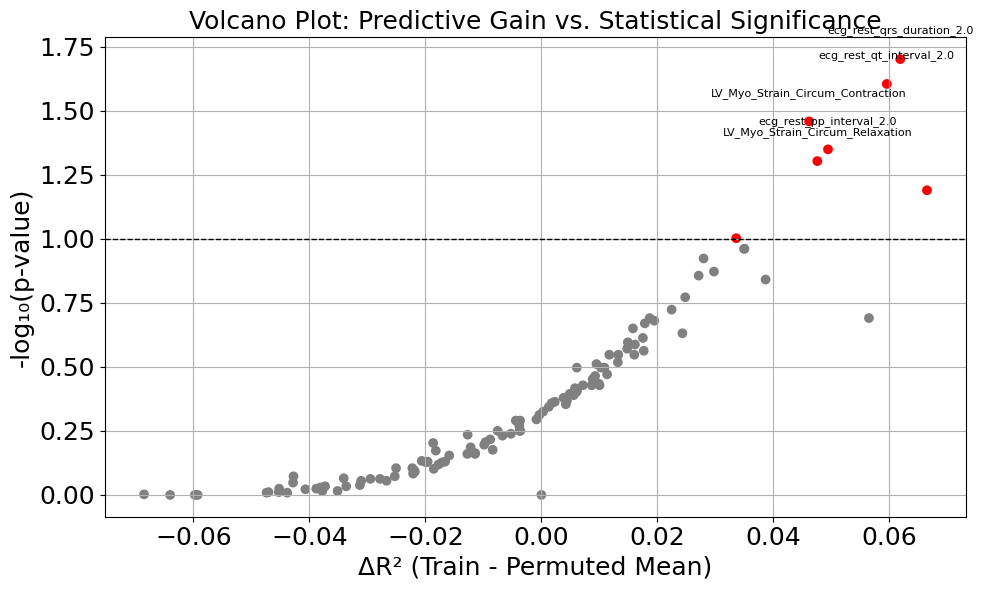

,R2_train,R2_perm_mean,R2_perm_std,p_value,fdr_corrected_p,sig_marker,r2_diff,neg_log_p
ecg_rest_qrs_duration_2.0,0.209734,0.147856,0.026537,0.019900,0.981075,*,0.061878,1.701136
ecg_rest_qt_interval_2.0,0.205850,0.146282,0.024251,0.024876,0.981075,*,0.059567,1.604226
LV_Myo_Strain_Circum_Contraction,0.196498,0.150332,0.024779,0.034826,0.981075,*,0.046166,1.458098
ecg_rest_pp_interval_2.0,0.195505,0.146078,0.025875,0.044776,0.981075,*,0.049426,1.348954
LV_Myo_Strain_Circum_Relaxation,0.194558,0.146978,0.026836,0.049751,0.981075,*,0.047581,1.303196
...,...,...,...,...,...,...,...,...
pwa_total_peripheral_resistance_2.0,0.078464,0.146989,0.029740,0.995025,1.000000,,-0.068525,0.002166
SBP_2.0,0.087614,0.146899,0.022758,1.000000,1.000000,,-0.059286,-0.000000
RV_Myo_Strain_Circum_Early_Relaxation,0.085592,0.149622,0.023017,1.000000,1.000000,,-0.064030,-0.000000
RV_Myo_Strain_Radial_Contraction,0.092381,0.152146,0.024567,1.000000,1.000000,,-0.059765,-0.000000


In [188]:
from statsmodels.stats.multitest import multipletests

# Apply multiple testing correction (FDR)
summary_df["fdr_corrected_p"] = multipletests(summary_df["p_value"], method="fdr_bh")[1]
summary_df["sig_marker"] = summary_df["p_value"].apply(lambda p: "*" if p < 0.1 else "")
summary_df.loc[summary_df["fdr_corrected_p"] < 0.1, "sig_marker"] = "**"
summary_df

# Compute values for volcano plot
summary_df["r2_diff"] = summary_df["R2_train"] - summary_df["R2_perm_mean"]
summary_df["neg_log_p"] = -np.log10(summary_df["p_value"])

# Plot
plt.figure(figsize=(10, 6))
colors = summary_df["p_value"] < 0.1
plt.scatter(summary_df["r2_diff"], summary_df["neg_log_p"], c=colors.map({True: "red", False: "gray"}))
plt.axhline(-np.log10(0.1), linestyle="--", color="black", linewidth=1)
plt.xlabel("ΔR² (Train - Permuted Mean)")
plt.ylabel("-log₁₀(p-value)")
plt.title("Volcano Plot: Predictive Gain vs. Statistical Significance")

# Annotate top features (optional)
top = summary_df[summary_df["p_value"] < 0.1].sort_values("neg_log_p", ascending=False).head(5)
for idx, row in top.iterrows():
    plt.text(row["r2_diff"], row["neg_log_p"] + 0.1, idx, fontsize=8, ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()

summary_df.sort_values(by='p_value', ascending=True)


In [185]:
assoc_df.to_csv(os.path.join(save_folder, 'association_ukb_pc.csv'))
assoc_df

,PC,Y_var,Correlation,p_value,p_value_corrected,Significant,Significant_NC
0,PC1,LV_Myo_Strain_Radial_Contraction,-0.104228,0.034217,0.998679,False,True
1,PC1,LV_Myo_Strain_Circum_Contraction,-0.038654,0.433360,0.998679,False,False
2,PC1,LV_Myo_Strain_Radial_Relaxation,-0.090735,0.065449,0.998679,False,False
3,PC1,LV_Myo_Strain_Circum_Relaxation,-0.049157,0.318974,0.998679,False,False
4,PC1,LV_Myo_Strain_Radial_Early_Relaxation,0.060515,0.219742,0.998679,False,False
...,...,...,...,...,...,...,...
6827,PC61,us_max_imt_240_2.0,-0.016209,0.742582,0.998679,False,False
6828,PC61,spiro_fvc_2.0,-0.048502,0.325479,0.998679,False,False
6829,PC61,spiro_pef_2.0,-0.076681,0.119728,0.998679,False,False
6830,PC61,RVMI,-0.001361,0.978000,0.998679,False,False


In [180]:
assoc_df.sort_values(by='p_value', ascending=True)

,PC,Y_var,Correlation,p_value,p_value_corrected,Significant,Significant_NC
3659,PC33,art_stiff_position_notch_2.0,-1.767280e-01,0.000307,0.998679,False,True
6335,PC57,ecg_rest_qt_interval_2.0,-1.748966e-01,0.000355,0.998679,False,True
6387,PC58,LV_Myo_Strain_Circum_Relaxation,1.613362e-01,0.001001,0.998679,False,True
394,PC4,pwa_cardiac_index_2.0,-1.611818e-01,0.001012,0.998679,False,True
6223,PC56,ecg_rest_qt_interval_2.0,-1.610534e-01,0.001021,0.998679,False,True
...,...,...,...,...,...,...,...
734,PC7,ecg_rest_pq_interval_2.0,-2.283162e-05,0.999631,0.999990,False,False
6164,PC56,LV_Myo_Strain_Radial_Early_Relaxation,1.413877e-05,0.999771,0.999990,False,False
3874,PC35,ecg_rest_pp_interval_2.0,-7.925334e-06,0.999872,0.999990,False,False
2382,PC22,RV_Myo_Max Radial Strain,2.384853e-06,0.999961,0.999990,False,False


In [181]:


# Step 5: Create heatmap data (only significant correlations)
# heatmap_data = assoc_df[assoc_df['Significant']].pivot(index='Y_var', columns='X_var', values='Correlation')
heatmap_data = assoc_df[assoc_df['Significant']].pivot(index='Y_var', columns='PC', values='Correlation')
heatmap_data = assoc_df[assoc_df['Significant_NC']].pivot(index='Y_var', columns='PC', values='Correlation')
# heatmap_data = assoc_df.pivot(index='Y_var', columns='PC', values='Correlation')

# Drop rows/columns with all NaNs
heatmap_data = heatmap_data.dropna(how='all', axis=0).dropna(how='all', axis=1)
# heatmap_data

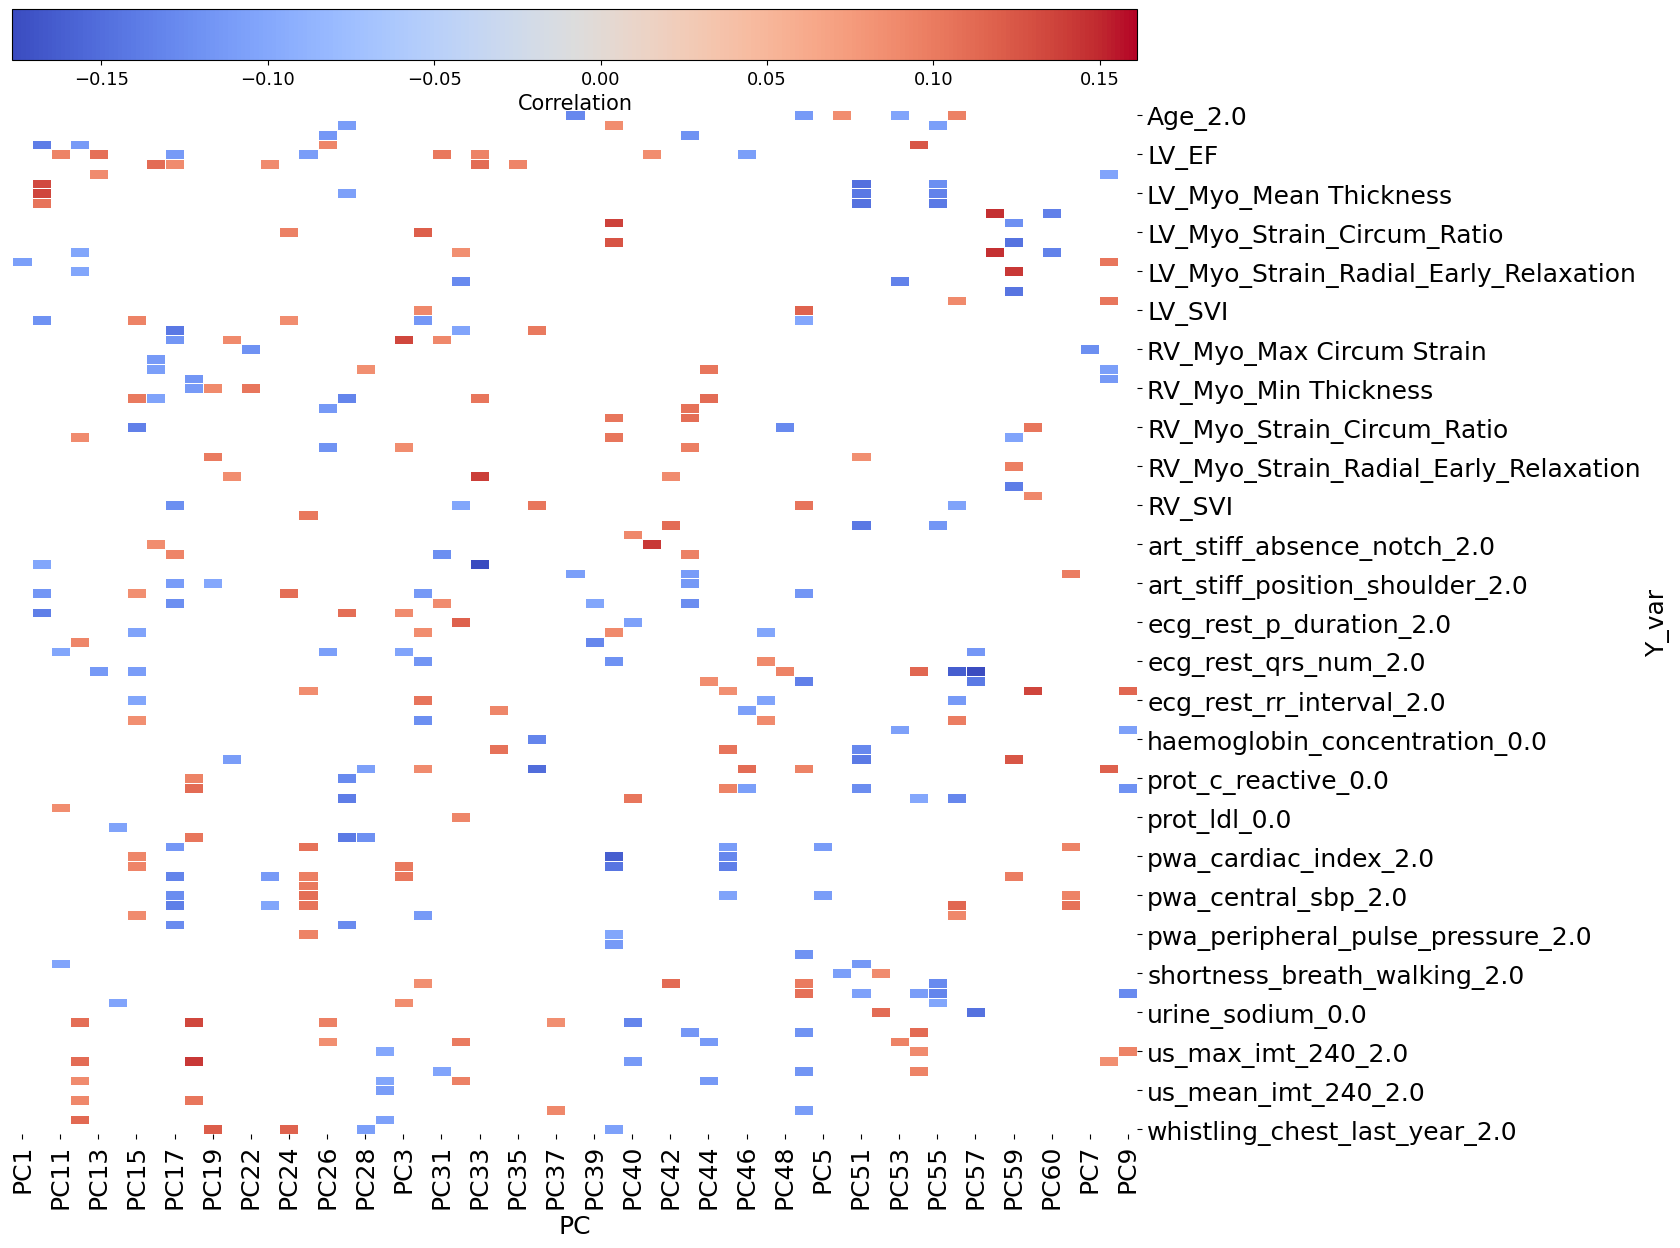

In [182]:
import matplotlib as mpl
mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 10
})

# Create the clustermap
g = sns.clustermap(
    heatmap_data,
    method='average',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    figsize=(15, 15),
    col_cluster=False,
    row_cluster=False,
    cbar=False,
)

# Manually add a horizontal colorbar on top
from matplotlib.colorbar import Colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create new colorbar axis above the heatmap
divider = make_axes_locatable(g.ax_heatmap)
cax = divider.append_axes("top", size="5%", pad=0.5)

# Create colorbar
norm = plt.Normalize(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
cbar = g.fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Correlation", fontsize=15)
cbar.ax.tick_params(labelsize=13)

# Remove dendrogram axes (even though clustering is disabled, the space remains)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# 🚫 This part is key: remove any axes left behind
for ax in g.fig.axes:
    if not hasattr(ax, 'has_data') or not ax.has_data():
        ax.remove()

# Resize heatmap to fill the space
g.ax_heatmap.set_position([0.1, 0.1, 0.75, 0.75])  # [left, bottom, width, height]

plt.show()

# Save the cleaned-up version
g.fig.savefig(os.path.join(save_folder, 'clustermap_correlations.eps'), dpi=300, bbox_inches='tight', format='eps')

In [ ]:

# Compute the correlation between the latent and the biomarkers    
corr_data = df_joined.corr()    

# Filter correlations to include only those between df_latent and df_data
latents = y_df.columns
data_vars = X_df.columns

# Create a mask for filtering the correlations
filtered_corrs = corr_data.loc[data_vars, latents]

# Optional: flatten the matrix for easier visualization
filtered_corrs = filtered_corrs.stack().reset_index()
filtered_corrs.columns = ['Latent Variable', 'Biomarker', 'Correlation']
filtered_corrs.to_csv(os.path.join(save_folder, 'correlation_data.csv'))

# Find high associations between the variables in df_latent and the variables in df_data
threshold = 0.15
significant_corrs = filtered_corrs[(filtered_corrs['Correlation'].abs() > threshold)]
significant_corrs = significant_corrs.sort_values(by='Correlation', ascending=False)
significant_corrs.reset_index(drop=True, inplace=True)
significant_corrs.to_csv(os.path.join(save_folder, 'significant_correlation_data.csv'))

print(np.unique(significant_corrs['Biomarker']))
significant_corrs

In [ ]:
# Create the clustermap
g = sns.clustermap(
    tmp_corr,
    method='average',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    figsize=(15, 15),
    col_cluster=False,
    row_cluster=False,
    cbar=False,
)

# Manually add a horizontal colorbar on top
from matplotlib.colorbar import Colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create new colorbar axis above the heatmap
divider = make_axes_locatable(g.ax_heatmap)
cax = divider.append_axes("top", size="5%", pad=0.5)

# Create colorbar
norm = plt.Normalize(vmin=significant_corrs.min().min(), vmax=significant_corrs.max().max())
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
cbar = g.fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Correlation", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Remove dendrogram axes (even though clustering is disabled, the space remains)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# 🚫 This part is key: remove any axes left behind
for ax in g.fig.axes:
    if not hasattr(ax, 'has_data') or not ax.has_data():
        ax.remove()

# Resize heatmap to fill the space
g.ax_heatmap.set_position([0.1, 0.1, 0.75, 0.75])  # [left, bottom, width, height]

plt.show()

# Save the cleaned-up version
g.fig.savefig(os.path.join(save_folder, 'clustermap_correlations.eps'), dpi=300, bbox_inches='tight', format='eps')


In [ ]:

# plt.figure(figsize=(10, 8))
sns.heatmap(pivot_corr, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('High Correlations Between Latent Variables and Biomarkers')
plt.show()

In [ ]:
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_df)
Y_scaled = StandardScaler().fit_transform(y_df)

# Assume: X_df = latent vars, Y_df = biomarkers
cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

# Projected canonical components
cca_df = pd.DataFrame({
    'Latent_1': X_c[:, 0],
    'Latent_2': X_c[:, 1],
    'Biomarker_1': Y_c[:, 0],
    'Biomarker_2': Y_c[:, 1],
    'Group': labels_groups  # Optional, for color
})

# Visualization: 2D CCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cca_df, x='Latent_1', y='Latent_2', hue='Group', style='Group', s=80)
plt.title('Canonical Correlation Projection (Latents)')
plt.grid(True)
plt.tight_layout()
plt.show()

canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print(canonical_corrs)


In [ ]:
# Weights for how original features contribute to canonical components
latent_weights = pd.DataFrame(cca.x_weights_, index=X_df.columns, columns=['Canonical 1', 'Canonical 2'])
biomarker_weights = pd.DataFrame(cca.y_weights_, index=y_df.columns, columns=['Canonical 1', 'Canonical 2'])

# Look at top contributors
print("Top latent contributors to Canonical 1:")
print(latent_weights['Canonical 1'].abs().sort_values(ascending=False).head())

print("Top biomarkers for Canonical 1:")
print(biomarker_weights['Canonical 1'].abs().sort_values(ascending=False).head())

# Look at top contributors to Canonical 2
print("Top latent contributors to Canonical 2:")
print(latent_weights['Canonical 2'].abs().sort_values(ascending=False).head())

print("Top biomarkers for Canonical 2:")
print(biomarker_weights['Canonical 2'].abs().sort_values(ascending=False).head())

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# Step 1: Prepare data
X = X_df.values  # latent variables
Y = y_df.values  # biomarkers

# Step 2: Define pipeline
pls_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pls', PLSRegression(n_components=2))
])

# Step 3: Fit model
pls_pipeline.fit(X, Y)

# Step 4: Transform to latent PLS space
X_pls, Y_pls = pls_pipeline.named_steps['pls'].transform(X, Y)

# Step 5: Check PLS weights (contributions of original variables)
x_weights = pd.DataFrame(pls_pipeline.named_steps['pls'].x_weights_, 
                         index=X_df.columns, 
                         columns=['PLS1', 'PLS2'])

y_weights = pd.DataFrame(pls_pipeline.named_steps['pls'].y_weights_, 
                         index=y_df.columns, 
                         columns=['PLS1', 'PLS2'])

print("Top predictors (X -> PLS1):")
print(x_weights['PLS1'].abs().sort_values(ascending=False).head())

print("Top predicted biomarkers (Y -> PLS1):")
print(y_weights['PLS1'].abs().sort_values(ascending=False).head())




In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# Score across all Y dimensions
scores = cross_val_score(pls_pipeline, X, Y, cv=5, scoring=make_scorer(r2_score, multioutput='uniform_average'))

print(f"Mean R² across folds: {np.mean(scores):.3f}")


In [ ]:
import torch

# Load the latent data ; to plot the latent trajecotories
# Load the data . pkl
data_filename = os.path.join(aha_data_folder, 'data.pkl')
data_model = torch.load(data_filename)
data_model.keys()

latent_space = data_model['latent_trajectories']
labels = data_model['labels'].numpy()
predictions = data_model['predictions']
labels_groups = data_model['labels']
labels_groups = labels_groups.numpy()

In [ ]:
rec_positions = data_model['rec_pos']
rec_positions_std = data_model['rec_pos_std']
tgt_positions = data_model['tgt_pos']

In [ ]:
import numpy as np
import pandas as pd

# Convert to numpy if needed
rec_np = rec_positions.numpy()
tgt_np = tgt_positions.numpy()

# Shape: (N, 3, R, T)
N, D, R, T = rec_np.shape

# Initialize storage
metrics = {
    'Dimension': [],
    'MAE': [],
    'MSE': [],
    'MAPE (%)': [],
    'MSPE (%)': [],
    'IQR (Abs Error)': []
}

dimension_names = ['X', 'Y', 'Z']

for d in range(D):  # For each dimension
    rec_d = rec_np[:, d, :, :].flatten()
    tgt_d = tgt_np[:, d, :, :].flatten()

    abs_err = np.abs(rec_d - tgt_d)
    sq_err = (rec_d - tgt_d) ** 2

    # Handle small values in denominator to avoid division by zero
    tgt_d_safe = np.clip(np.abs(tgt_d), 1e-8, None)

    mae = np.mean(abs_err)
    mse = np.mean(sq_err)
    mape = np.mean(abs_err / tgt_d_safe) * 100
    mspe = np.mean(sq_err / tgt_d_safe) * 100
    iqr = np.percentile(abs_err, 75) - np.percentile(abs_err, 25)

    # Store metrics
    metrics['Dimension'].append(dimension_names[d])
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['MAPE (%)'].append(mape)
    metrics['MSPE (%)'].append(mspe)
    metrics['IQR (Abs Error)'].append(iqr)

# Create and display DataFrame
df_metrics = pd.DataFrame(metrics)
print(df_metrics)


In [ ]:
unique_groups = sorted(set(labels_groups))
unique_groups
dcit_labels = data_model['dict_labels']
print(dcit_labels)
dcit_labels[1] = "AFib"
dcit_labels[0] = "Control"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

import matplotlib as mpl
mpl.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 10
})

# data, target: shape [N, 3, R, T]
N, D, R, T = rec_positions.shape

# Assume clinical_groups is a list of N labels (e.g., 'control', 'patient', etc.)
unique_groups = sorted(set(labels_groups))
colors = cm.get_cmap('tab10', len(unique_groups))
group_to_color = {group: colors(i) for i, group in enumerate(unique_groups)}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for group in unique_groups:
    # Indices for this group
    indices = [i for i, g in enumerate(labels_groups) if g == group]
    
    # Mean over subjects in the group: shape [3, R, T]
    rec_mean = rec_positions[indices].mean(dim=0) if hasattr(rec_positions, 'mean') else np.mean(rec_positions[indices], axis=0)
    tgt_mean = tgt_positions[indices].mean(dim=0) if hasattr(tgt_positions, 'mean') else np.mean(tgt_positions[indices], axis=0)

    x_rec, y_rec = rec_mean[0], rec_mean[1]  # Shape: [R, T]
    x_tgt, y_tgt = tgt_mean[0], tgt_mean[1]

    color = group_to_color[group]
    label_group = dcit_labels[int(group)]
    # Plot each region's trajectory
    for region in range(R):
        # Reconstructed (solid line)
        plt.plot(x_rec[region], y_rec[region], color=color, linestyle='-', linewidth=2, alpha=0.8, label=f'{label_group} (recon)' if region == 0 else "")
        # Target (dashed line)
        plt.plot(x_tgt[region], y_tgt[region], color=color, linestyle='--', linewidth=2, alpha=0.8, label=f'{label_group} (target)' if region == 0 else "")

# Build legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Group & Type", fontsize=11)

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")
plt.title("Mean Region Trajectories (X vs Y) per Clinical Group\nSolid = Reconstructed | Dashed = Target")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(save_folder, 'mean_region_trajectories.eps'), dpi=300, bbox_inches='tight', format='eps')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Example setup (replace this with your actual data)
# data shape: [N, 3, R, T]
N, D, R, T = rec_positions.shape

# Assume: clinical_groups is a list or array of length N
# Example: clinical_groups = ['control', 'patient', 'control', ...]
unique_groups = sorted(set(labels_groups))
group_to_color = {group: color for group, color in zip(unique_groups, cm.get_cmap('tab10').colors)}

plt.figure(figsize=(12, 12))

# for subject_idx in range(N):
for subject_idx in range(1):
    group = labels_groups[subject_idx]
    color = group_to_color[group]

    x = rec_positions[subject_idx, 0].numpy()  # Shape: [R, T]
    y = rec_positions[subject_idx, 1].numpy()  # Shape: [R, T]

    # Plot each region trajectory
    for region_idx in range(R):
        plt.plot(x[region_idx], y[region_idx], color=color, alpha=0.8)

# Legend handles (1 per group)
handles = [plt.Line2D([0], [0], color=group_to_color[g], lw=3, label=g) for g in unique_groups]
plt.legend(handles=handles, title="Clinical Group")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Region Trajectories Across All Subjects")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
print(latent_space.shape, labels.shape)
subjects, fts, regions, frames  = latent_space.shape

time = np.arange(latent_space.shape[3])  # Frames (time)

# Define unique labels and assign colors
unique_labels = np.unique(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Color map for labels
label_colors = {label: color for label, color in zip(unique_labels, colors)}


In [ ]:
# Plot each feature separately
# regions = np.array([1]).astype(int)
for feature_idx in range(fts):
    plt.figure(figsize=(10, 6))
    
    # Plot each subject's data for the current feature
    for subject_idx in range(subjects):
        subject_data = latent_space[subject_idx, feature_idx]  # Shape: (regions, frames)
        
        # Plot all regions for this subject
        # for region_idx in regions:
        for region_idx in np.arange(1):
            plt.plot(
                np.arange(frames),  # Time axis
                subject_data[region_idx],  # Data for the region
                color=label_colors[labels[subject_idx]],
                alpha=0.7,
                label=f'Region {region_idx + 1}' if subject_idx == 0 else None  # Avoid duplicate legends
            )
    
    # Add labels and legend
    plt.title(f"Feature {feature_idx + 1} - Evolution Over Time")
    plt.xlabel("Time (Frames)")
    plt.ylabel("Feature Value")
    plt.legend(loc='upper right', title="Regions", bbox_to_anchor=(1.3, 1))
    plt.show()

In [ ]:
region = np.array([6]).astype(int)
for feature_idx in range(fts):
    plt.figure(figsize=(10, 6))
    
    # Process each label group separately
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_mask = labels == label  # Mask for subjects with the current label
        label_color = label_colors[label]  # Get color for this label

        # Compute mean and std across subjects for each region
        # for region_idx in range(1):  # Change range(regions) to plot all regions        
        for region_idx in region:
            region_idx = int(region_idx)
            region_data = latent_space[label_mask, feature_idx, region_idx, :]  # Shape: (subjects_per_label, frames)
            
            # Calculate mean and std dev over subjects with this label
            mean_data = np.mean(region_data, axis=0)
            std_dev = np.std(region_data, axis=0)
            
            # Plot mean with a shaded area for std dev
            plt.plot(
                np.arange(frames), 
                mean_data, 
                label=f"Label {label}, Region {region_idx + 1}",
                color=label_color
            )
            plt.fill_between(
                np.arange(frames),
                mean_data - std_dev,
                mean_data + std_dev,
                alpha=0.3,
                color=label_color
            )
    
    # Add labels and legend
    plt.title(f"Feature {feature_idx + 1} - Mean and Std Dev Per Label")
    plt.xlabel("Time (Frames)")
    plt.ylabel("Feature Value")
    plt.legend(loc='upper right', title="Labels and Regions", bbox_to_anchor=(1.3, 1))
    plt.show()


In [ ]:
# Define regions of interest
regions = np.array([6, 7]).astype(int)

for feature_idx in range(fts):
    plt.figure(figsize=(8, 8))
    
    # Process each label group separately
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_mask = labels == label  # Mask for subjects with the current label
        label_color = label_colors[label]  # Get color for this label

        # Get data for the two regions of interest
        region_6_data = latent_space[label_mask, feature_idx, regions[0], :]  # Region 6
        region_7_data = latent_space[label_mask, feature_idx, regions[1], :]  # Region 7

        # Compute mean trajectory (or other statistics)
        mean_region_6 = np.mean(region_6_data, axis=0)
        mean_region_7 = np.mean(region_7_data, axis=0)
        
        # Plot the 2D trajectory
        plt.plot(
            mean_region_6, 
            mean_region_7, 
            label=f"Label {label}",
            color=label_color,
            alpha=0.8,
        )
        
        # Optional: Add markers to indicate time points
        plt.scatter(mean_region_6, mean_region_7, color=label_color, alpha=0.5, s=10)
    
    # Add labels, legend, and axis labels
    plt.title(f"Feature {feature_idx + 1} - 2D Trajectory Between Regions")
    plt.xlabel(f"Region {regions[0] + 1} Mean Value")
    plt.ylabel(f"Region {regions[1] + 1} Mean Value")
    plt.legend(loc='upper right', title="Labels")
    plt.grid(True)
    plt.show()


In [ ]:
# Select the features you want to compare
feature_1, feature_2 = 6, 7  # Indices of the features you want to plot
regions = np.arange(0, 10)
# Process each region
for region_idx in regions:
    region_idx = int(region_idx)
    plt.figure(figsize=(8, 8))
    
    # Process each label group separately
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_mask = labels == label  # Mask for subjects with the current label
        label_color = label_colors[label]  # Get color for this label

        # Extract data for the selected features for the current region
        data_feature_1 = latent_space[label_mask, feature_1, region_idx, :]  # Shape: (subjects_per_label, frames)
        data_feature_2 = latent_space[label_mask, feature_2, region_idx, :]  # Shape: (subjects_per_label, frames)
        
        # Compute mean trajectory across subjects
        mean_feature_1 = np.mean(data_feature_1, axis=0)
        mean_feature_2 = np.mean(data_feature_2, axis=0)
        
        # Plot the trajectory
        plt.plot(
            mean_feature_1, 
            mean_feature_2, 
            label=f"Label {label}",
            color=label_color,
            alpha=0.8,
        )

        # Plot also the individual trajectories
        # for subject_idx in range(data_feature_1.shape[0]):
        #     plt.plot(
        #         data_feature_1[subject_idx], 
        #         data_feature_2[subject_idx], 
        #         color=label_color,
        #         alpha=0.2,
        #     )
        
        # Optional: Add markers for time points
        plt.scatter(mean_feature_1, mean_feature_2, color=label_color, alpha=0.5, s=10)
    
    # Add plot details
    plt.title(f"Region {region_idx + 1} - Trajectories of Feature {feature_1 + 1} vs {feature_2 + 1}")
    plt.xlabel(f"Feature {feature_1 + 1} Value")
    plt.ylabel(f"Feature {feature_2 + 1} Value")
    plt.legend(loc='upper right', title="Labels")
    plt.grid(True)
    plt.show()
